In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from sklearn.datasets import fetch_california_housing
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from IPython.display import display
from sklearn.preprocessing import LabelEncoder

# Loading data and concatenating with original

In [3]:
# setting a base_dir so we don't have to type all the paths
BASE_DIR = Path("/kaggle/input/playground-series-s3e1/")

In [4]:
train_df = pd.read_csv(BASE_DIR / "train.csv")
test_df = pd.read_csv(BASE_DIR / "test.csv")

original_df = fetch_california_housing(as_frame=True)
original_df = original_df["frame"]

train_large = pd.concat([train_df, original_df], axis=0).drop_duplicates().reset_index(drop=True)

# Some preprocessing

In [5]:
cols_to_use = train_large.columns[1:-1]
display(cols_to_use)
display(len(cols_to_use))

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

8

In [6]:
train_large.drop(columns=["id"], axis=1, inplace=True)

In [7]:
test_df.drop(columns=["id"], axis=1, inplace=True)

In [8]:
train_large.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [9]:
df = pd.concat([train_large, test_df], axis=0, ignore_index=True)

# Feature Engineering

Copying all the feature engineering from https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory

## Encoding Trick

In [10]:
emb_size = 20
precision = 1e6 

latlon = np.expand_dims(df[['Latitude', 'Longitude']].values, axis=-1) 

# display(latlon)
# display(latlon.shape)

m = np.exp(np.log(precision) / emb_size) 

angle_freq = m ** np.arange(emb_size) 
angle_freq = angle_freq.reshape(1, 1, emb_size) 

latlon = latlon * angle_freq 
latlon[..., 0::2] = np.cos(latlon[..., 0::2]) 
latlon[..., 1::2] = np.sin(latlon[..., 1::2]) 
latlon = latlon.reshape(-1, 2 * emb_size) 

In [11]:
df['exp_latlon1'] = [lat[0] for lat in latlon]
df['exp_latlon2'] = [lat[1] for lat in latlon]

## Coords with PCA & UMAP

In [12]:
from sklearn.decomposition import PCA

coordinates = df[['Latitude', 'Longitude']].values
pca = PCA().fit(coordinates)

df['pca_lat'] = pca.transform(coordinates)[:,0]
df['pca_lon'] = pca.transform(coordinates)[:,1]

In [14]:
from umap import UMAP
umap = UMAP(n_components=2, n_neighbors=50, random_state=228).fit(coordinates)
df['umap_lat'] = umap.transform(coordinates)[:,0]
df['umap_lon'] = umap.transform(coordinates)[:,1]

## Cartesian Coords Rotation

In [15]:
df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                  (np.sin(np.radians(15)) * df['Latitude'])
    
df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) + \
                  (np.sin(np.radians(15)) * df['Longitude'])
    
df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                  (np.sin(np.radians(30)) * df['Latitude'])
    
df['rot_30_y'] = (np.cos(np.radians(30)) * df['Latitude']) + \
                  (np.sin(np.radians(30)) * df['Longitude'])
    
df['rot_45_x'] = (np.cos(np.radians(44)) * df['Longitude']) + \
                  (np.sin(np.radians(45)) * df['Latitude'])

## Coords Location

In [16]:
!pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=24b47a50c5d29c860e941820c6cab05617542e401e127aeed114be24c69c83cc
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse_geocoder


In [17]:
import reverse_geocoder as rg

coordinates = list(zip(df['Latitude'], df['Longitude']))
results = rg.search(coordinates)
df['place'] = [x['admin2'] for x in results]

places = ['Los Angeles County', 'Orange County', 'Kern County',
          'Alameda County', 'San Francisco County', 'Ventura County',
          'Santa Clara County', 'Fresno County', 'Santa Barbara County',
          'Contra Costa County', 'Yolo County', 'Monterey County',
          'Riverside County', 'Napa County']

def replace(x):
    if x in places:
        return x
    else:
        return 'Other'
    
df['place'] = df['place'].apply(lambda x: replace(x))
le = LabelEncoder()
df['place'] = le.fit_transform(df['place'])

Loading formatted geocoded file...


# Distance to Cities and Coast Lines

In [18]:
from haversine import haversine

Sac = (38.576931, -121.494949)
SF = (37.780080, -122.420160)
SJ = (37.334789, -121.888138)
LA = (34.052235, -118.243683)
SD = (32.715759, -117.163818)

df['dist_Sac'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), Sac, unit='ft'), axis=1)
df['dist_SF'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SF, unit='ft'), axis=1)
df['dist_SJ'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SJ, unit='ft'), axis=1)
df['dist_LA'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), LA, unit='ft'), axis=1)
df['dist_SD'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SD, unit='ft'), axis=1)
df['dist_nearest_city'] = df[['dist_Sac', 'dist_SF', 'dist_SJ', 
                              'dist_LA', 'dist_SD']].min(axis=1)

In [19]:
from shapely.geometry import LineString, Point

coast_points = LineString([(32.6644, -117.1613), (33.2064, -117.3831),
                           (33.7772, -118.2024), (34.4634, -120.0144),
                           (35.4273, -120.8819), (35.9284, -121.4892),
                           (36.9827, -122.0289), (37.6114, -122.4916),
                           (38.3556, -123.0603), (39.7926, -123.8217),
                           (40.7997, -124.1881), (41.7558, -124.1976)])

df['dist_to_coast'] = df.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)

In [20]:
# saving the dataset to save time for futher experiments
df.to_csv("playground-s03e01-ultimate.csv", index=False)

# Preprocessing v2 - Could be final

In [21]:
train = df.iloc[:-len(test_df),:]
test = df.iloc[-len(test_df):,:].drop('MedHouseVal', axis=1).reset_index(drop=True)

X = train.drop('MedHouseVal', axis=1)
y = train['MedHouseVal']

# Modeling

## First, let's train the same XGBoost model from Simple Baseline to see how much all this feature engineering makes a difference

In [22]:
# just randomly chosen param values for now
xgb_params = {
    'eta': 0.1,
    'max_depth': 8,
    'min_child_weight': 1,
    'colsample_bytree': 1,
    'eval_metric': 'mae',
    'seed': 1337,
}

In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=1333)

all_folds = np.zeros(len(X))

def cross_validate(kf, X_train, y_train, model):
    for fold, (idx_tr, idx_val) in enumerate(kf.split(X_train)):
        X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
        
        X_val, y_val = X_train[idx_val], y_train[idx_val]
        
#         if model == "xgb":
#             dtrain = xgb.DMatrix(X_tr, label=y_tr)
#             dval = xgb.DMatrix(X_val)

#             model = xgb.train(xgb_params, dtrain, num_boost_round=300)
        
#             y_pred = model.predict(dval)
        
#         if model == "keras":
#             hist = model.fit(X_tr.values, y_tr, epoch)
        
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            
        
        all_folds[idx_val] = y_pred
        
        val_rmse = mse(y_val, y_pred, squared=False)
        
        print(f"Fold: {fold} \t RMSE: {val_rmse:.4}")
    
    
    # RMSE of all the cross validations
    avg_rmse = mse(y_train, all_folds, squared=False)
    print(f"Average RMSE: {avg_rmse:.4}")
    
    return avg_rmse

In [46]:
cross_validate(kf, X.values, y.values, model="xgb")

Fold: 0 	 RMSE: 0.5234
Fold: 1 	 RMSE: 0.5327
Fold: 2 	 RMSE: 0.5298
Fold: 3 	 RMSE: 0.5223
Fold: 4 	 RMSE: 0.5235
Fold: 5 	 RMSE: 0.5396
Fold: 6 	 RMSE: 0.5238
Fold: 7 	 RMSE: 0.5113
Fold: 8 	 RMSE: 0.5125
Fold: 9 	 RMSE: 0.5214
Average RMSE: 0.5241


#### INSIGHTS: Looks like there's definitely improvement

### Okay, let's now try to tune xgboost model and see how better can we get this thing.
#### Then we'll move on to training, tuning and ensebmling other models

In [23]:
import optuna

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
# cross validate function to assist with parameters tuning
def cross_validate(kf, X_train, y_train, model):
    
    all_folds = np.zeros(len(X_train))
    
    for fold, (idx_tr, idx_val) in enumerate(kf.split(X_train)):
        X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
        
        X_val, y_val = X_train[idx_val], y_train[idx_val]
        
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
        
        y_pred = model.predict(y_val)
        
        all_folds[idx_val] = y_pred
        
        val_rmse = mse(y_val, y_pred, squared=False)
        
        print(f"Fold: {fold} \t RMSE: {val_rmse:.4}")
    
    
    # RMSE of all the cross validations
    avg_rmse = mse(y_train, all_folds, squared=False)
    print(f"Average RMSE: {avg_rmse:.4}")
    
    return avg_rmse

In [56]:
# creating optuna objective function
# following the tutorial from https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning

kf = KFold(n_splits=5, shuffle=True, random_state=1337)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=1337)


def objective(trial):
    """Defining the objective function"""
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'rmse',
        'use_label_encoder': False,
        'early_stopping_rounds': 50,
    }
    
    # Fit the model
    optuna_model = xgb.XGBRegressor(**params)
    optuna_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    rmse = mse(y_test, y_pred, squared=True)
    
    return rmse

In [62]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', study_name="xgb_tuner")

In [63]:
study.optimize(objective, n_trials=100, show_progress_bar=True)

[341]	validation_0-rmse:0.52233
[342]	validation_0-rmse:0.52230
[343]	validation_0-rmse:0.52232
[344]	validation_0-rmse:0.52231
[345]	validation_0-rmse:0.52234
[346]	validation_0-rmse:0.52234
[347]	validation_0-rmse:0.52237
[348]	validation_0-rmse:0.52238
[349]	validation_0-rmse:0.52238
[350]	validation_0-rmse:0.52237
[351]	validation_0-rmse:0.52231
[352]	validation_0-rmse:0.52227
[353]	validation_0-rmse:0.52229
[354]	validation_0-rmse:0.52231
[355]	validation_0-rmse:0.52230
[356]	validation_0-rmse:0.52233
[357]	validation_0-rmse:0.52233
[358]	validation_0-rmse:0.52228
[359]	validation_0-rmse:0.52224
[360]	validation_0-rmse:0.52225
[361]	validation_0-rmse:0.52225
[362]	validation_0-rmse:0.52227
[363]	validation_0-rmse:0.52229
[364]	validation_0-rmse:0.52228
[365]	validation_0-rmse:0.52229
[366]	validation_0-rmse:0.52230
[367]	validation_0-rmse:0.52227
[368]	validation_0-rmse:0.52229
[369]	validation_0-rmse:0.52230
[370]	validation_0-rmse:0.52229
[371]	validation_0-rmse:0.52228
[372]	va

In [65]:
study.best_value

0.25889852872185887

In [66]:
study.best_params

{'n_estimators': 456,
 'max_depth': 8,
 'learning_rate': 0.026812575512866303,
 'min_child_weight': 10,
 'gamma': 0.22149150031512366,
 'subsample': 0.6211899414778005,
 'colsample_bytree': 0.32874025570599114,
 'reg_alpha': 1.5211300201400934e-05,
 'reg_lambda': 0.0005497911242012908}

In [67]:
study.best_trial

FrozenTrial(number=74, values=[0.25889852872185887], datetime_start=datetime.datetime(2023, 1, 8, 16, 10, 12, 926651), datetime_complete=datetime.datetime(2023, 1, 8, 16, 10, 38, 664910), params={'n_estimators': 456, 'max_depth': 8, 'learning_rate': 0.026812575512866303, 'min_child_weight': 10, 'gamma': 0.22149150031512366, 'subsample': 0.6211899414778005, 'colsample_bytree': 0.32874025570599114, 'reg_alpha': 1.5211300201400934e-05, 'reg_lambda': 0.0005497911242012908}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 're

## Let's now train a deep learning model and see how it performs comparatively
#### then we move on to hyperparamter tuning and emsembling

### Scaling data
Since deep models need the data to be scaled, so lets's first do that

In [49]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)

In [58]:
inputs = layers.Input(shape=X.shape[1])
x = layers.Dense(512, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

In [59]:
keras_model = keras.Model(inputs=inputs, outputs=outputs)
# keras.utils.plot_model(keras_model, show_shapes=True)

In [69]:
keras_model.compile(optimizer="rmsprop",
                   loss=keras.losses.mean_squared_error,
                   metrics=[keras.metrics.RootMeanSquaredError()])

In [70]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    monitor="val_root_mean_squared_error",
    restore_best_weights=True,
)

In [71]:
history = keras_model.fit(
    X_scaled, y,
    validation_split=0.2,
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
91/91 [==============================] - 6s 38ms/step - loss: 3.6703 - root_mean_squared_error: 1.9158 - val_loss: 1.4417 - val_root_mean_squared_error: 1.2007
Epoch 2/200
91/91 [==============================] - 3s 36ms/step - loss: 1.3252 - root_mean_squared_error: 1.1512 - val_loss: 0.5113 - val_root_mean_squared_error: 0.7150
Epoch 3/200
91/91 [==============================] - 3s 36ms/step - loss: 0.8357 - root_mean_squared_error: 0.9142 - val_loss: 0.4824 - val_root_mean_squared_error: 0.6945
Epoch 4/200
91/91 [==============================] - 4s 40ms/step - loss: 0.6307 - root_mean_squared_error: 0.7942 - val_loss: 0.4802 - val_root_mean_squared_error: 0.6929
Epoch 5/200
91/91 [==============================] - 3s 36ms/step - loss: 0.5206 - root_mean_squared_error: 0.7215 - val_loss: 0.4391 - val_root_mean_squared_error: 0.6626
Epoch 6/200
91/91 [==============================] - 3s 35ms/step - loss: 0.4722 - root_mean_squared_error: 0.6872 - val_loss: 0.6233 - val_

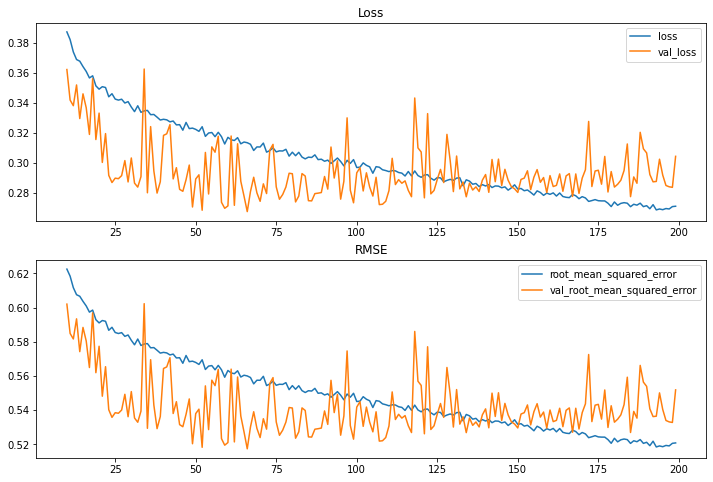

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(12,8))
# fig(figsize=(12,8))
history_df = pd.DataFrame(history.history)
history_df.loc[10:, ["loss", "val_loss"]].plot(title="Loss", ax=ax[0])
history_df.loc[10:, ["root_mean_squared_error", "val_root_mean_squared_error"]].plot(title="RMSE", ax=ax[1])
plt.show()